In [1]:
import os
import math
from tqdm import tqdm
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
import threestudio
import gc
import time
import io

import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Output
from IPython.display import display, clear_output
from PIL import Image

def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, num_cycles: float = 0.5):

    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return LambdaLR(optimizer, lr_lambda, -1)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
# To specify the gpu you want to use, we recommend to start the jupyter server with CUDA_VISIBLE_DEVICES=<gpu_ids>.
# threestudio.utils.base.get_device = lambda: torch.device('cuda:0') # hack the cuda device

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
prompt = "An astronaut riding a horse in space"
print(prompt)

An astronaut riding a horse in space


In [6]:
# stable diffusion 
config = {
    'max_iters': 1000,
    'seed': 42,
    'scheduler': 'cosine',
    'mode': 'latent',
    'prompt_processor_type': 'stable-diffusion-prompt-processor',
    'prompt_processor': {
        'prompt': prompt,
    },
    'guidance_type': 'stable-diffusion-guidance',
    'guidance': {
        'half_precision_weights': False,
        'guidance_scale': 100.,
        'pretrained_model_name_or_path': '/remote-home/share/Models/stabilityai/stable-diffusion-2-1',
        'grad_clip': None,
        'view_dependent_prompting': False,
    },
    'image': {
        'width': 64,
        'height': 64,
    }
}
seed_everything(config['seed'])

In [7]:
# just need to rerun the cell when you change guidance or prompt_processor
guidance = None
prompt_processor = None
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

guidance = threestudio.find(config['guidance_type'])(config['guidance'])
prompt_processor = threestudio.find(config['prompt_processor_type'])(config['prompt_processor'])
prompt_processor.configure_text_encoder()

Loading Stable Diffusion ...


Loading pipeline components...:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded Stable Diffusion!
Using prompt [An astronaut riding a horse in space] and negative prompt []
Using view-dependent prompts [side]:[An astronaut riding a horse in space, side view] [front]:[An astronaut riding a horse in space, front view] [back]:[An astronaut riding a horse in space, back view] [overhead]:[An astronaut riding a horse in space, overhead view]
tokenizer/tokenizer_config.json: 100%|██████████| 806/806 [00:00<00:00, 140kB/s]
tokenizer/vocab.json: 100%|██████████| 1.06M/1.06M [00:01<00:00, 885kB/s]
tokenizer/merges.txt: 100%|██████████| 525k/525k [00:00<00:00, 570kB/s]
tokenizer/special_tokens_map.json: 100%|██████████| 472/472 [00:00<00:00, 421kB/s]


In [9]:
def figure2image(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

def configure_other_guidance_params_manually(guidance, config):
    # avoid reloading guidance every time change these params
    guidance.cfg.grad_clip = config['guidance']['grad_clip']
    guidance.cfg.guidance_scale = config['guidance']['guidance_scale']

def run(config):
    # clear gpu memory
    rgb = None
    grad = None
    vis_grad = None
    vis_grad_norm = None
    loss = None
    optimizer = None
    target = None

    gc.collect()
    with torch.no_grad():
        torch.cuda.empty_cache()
    
    configure_other_guidance_params_manually(guidance, config)

    mode = config['mode']
    
    w, h = config['image']['width'], config['image']['height']
    if mode == 'rgb':
        target = nn.Parameter(torch.rand(1, h, w, 3, device=guidance.device))
    else:
        target = nn.Parameter(torch.randn(1, h, w, 4, device=guidance.device))

    optimizer = torch.optim.AdamW([target], lr=1e-1, weight_decay=0)
    num_steps = config['max_iters']
    scheduler = get_cosine_schedule_with_warmup(optimizer, 100, int(num_steps*1.5)) if config['scheduler'] == 'cosine' else None

    rgb = None
    plt.axis('off')

    img_array = []

    try:
        for step in tqdm(range(num_steps + 1)):
            optimizer.zero_grad()

            batch = {
                'elevation': torch.Tensor([0]),
                'azimuth': torch.Tensor([0]),
                'camera_distances': torch.Tensor([1]),
            }

            loss = guidance(target, prompt_processor(), **batch, rgb_as_latents=(mode != 'rgb'))
            loss['loss_sds'].backward()

            grad = target.grad
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            
            guidance.update_step(epoch=0, global_step=step)

            if step % 5 == 0:
                if mode == 'rgb':
                    rgb = target
                    vis_grad = grad[..., :3]
                    vis_grad_norm = grad.norm(dim=-1)
                else:
                    rgb = guidance.decode_latents(target.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
                    vis_grad = grad
                    vis_grad_norm = grad.norm(dim=-1)
                
                vis_grad_norm = vis_grad_norm / vis_grad_norm.max()
                vis_grad = vis_grad / vis_grad.max()
                img_rgb = rgb.clamp(0, 1).detach().squeeze(0).cpu().numpy()
                img_grad = vis_grad.clamp(0, 1).detach().squeeze(0).cpu().numpy()
                img_grad_norm = vis_grad_norm.clamp(0, 1).detach().squeeze(0).cpu().numpy()

                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(img_rgb)
                ax[1].imshow(img_grad)
                ax[2].imshow(img_grad_norm)
                ax[0].axis('off')
                ax[1].axis('off')
                ax[2].axis('off')
                clear_output(wait=True)
                plt.show()
                img_array.append(figure2image(fig))
    except KeyboardInterrupt:
        pass
    finally:
        # browse the result
        print("Optimizing process:")
        images = img_array
        
        if len(images) > 0:
            # Set up the widgets
            slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
            output = Output()

            def display_image(index):
                with output:
                    output.clear_output(wait=True)
                    display(images[index])

            # Link the slider to the display function
            interact(display_image, index=slider)

            # Display the widgets
            # display(slider)
            display(output)

  0%|                                                                 | 0/1001 [00:00<?, ?it/s]


Optimizing process:


RuntimeError: mat1 and mat2 shapes cannot be multiplied (154x768 and 1024x320)

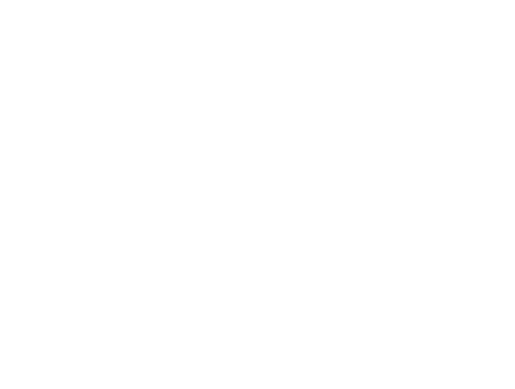

In [11]:
config['mode'] = 'rgb'
run(config)